In [137]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("paper.mplstyle")

import dicts
from scipy.special import gamma
from scipy.optimize import broyden1
from scipy.interpolate import UnivariateSpline

sd_limits = dicts.sd_limit_dict
sd_anns   = dicts.sd_ann_rate_dict # annihilation rate for xs=1pb

In [2]:
data_path = "/data/user/jlazar/solar_WIMP/data/"

min_exp   = 0.5
max_exp   = 6.5

chs = [5, 8, 11]
ms  = [300,500,1000,3000,5000,10000]

mu_pion         = np.load("%s/e_d_theta_hist/pion_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_pion_bar     = np.load("%s/e_d_theta_hist/pion_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon         = np.load("%s/e_d_theta_hist/kaon_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon_bar     = np.load("%s/e_d_theta_hist/kaon_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_bg_tot       = mu_pion + mu_pion_bar + mu_kaon + mu_kaon_bar

In [149]:
bb_lims = np.genfromtxt("data/3y_sd_bb_limits.csv", delimiter=",").T
ww_lims = np.genfromtxt("data/3y_sd_ww_limits.csv", delimiter=",").T
tt_lims = np.genfromtxt("data/3y_sd_tt_limits.csv", delimiter=",").T

bb_sens = np.genfromtxt("data/3yr_bb_sens.csv", delimiter=",").T
ww_sens = np.genfromtxt("data/3yr_ww_sens.csv", delimiter=",").T
tt_sens = np.genfromtxt("data/3yr_tt_sens.csv", delimiter=",").T

lims = [bb_lims, ww_lims, tt_lims]
lim_funcs = {}
for i, ch in enumerate(chs):
    lim_funcs[ch] = UnivariateSpline(np.log10(lims[i][0]), np.log10(lims[i][1]), k=3, s=1e-2)
    
senss = [bb_sens, ww_sens, tt_sens]
sens_funcs = {}
for i, ch in enumerate(chs):
    sens_funcs[ch] = UnivariateSpline(np.log10(senss[i][0]), np.log10(senss[i][1]), k=3, s=1e-2)
    
def get_limit(x, ch):
    log10x = np.log10(x)
    return np.power(10, lim_funcs[ch](log10x))
def get_sens(x, ch):
    log10x = np.log10(x)
    return np.power(10, sens_funcs[ch](log10x))

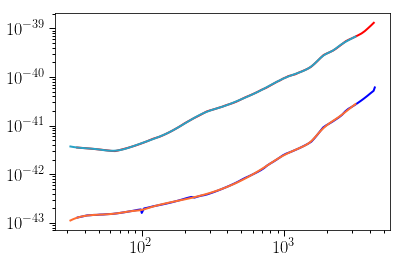

In [5]:
red_bound  = np.genfromtxt("sd_xc_floor_red.csv", delimiter=",").T
blue_bound = np.genfromtxt("sd_xc_floor_blue.csv", delimiter=",").T

rs = UnivariateSpline(np.log10(red_bound[0]), np.log10(red_bound[1]),s=1e-3)
bs = UnivariateSpline(np.log10(blue_bound[0]), np.log10(blue_bound[1]),s=1e-2)
def get_bound(m, bound):
    lm = np.log10(m)
    if bound=="red":
        s = rs
    elif bound=="blue":
        s = bs
    else:
        print("wrong bound buddy")
    return np.power(10, s(lm))

plt.plot(red_bound[0], red_bound[1], "r")
plt.plot(np.logspace(1.5,3.5, 100),get_bound(np.logspace(1.5,3.5, 100),"red"))
plt.plot(blue_bound[0], blue_bound[1], "b")
plt.plot(np.logspace(1.5,3.5, 100),get_bound(np.logspace(1.5,3.5, 100),"blue"))


plt.loglog()
plt.show()

In [6]:
def round_sig_figs(x, sig_figs=2):
    return round(x, sig_figs-int(np.floor(np.log10(abs(x))))-1)

In [7]:
def factorial(x):
    x = np.asarray(x)
    return gamma(x+1)

In [8]:
class poisson():
    
    def __init__(self, mu):
        self.mu      = mu
        self.var     = mu
        self.std     = np.sqrt(mu)
        self.mean    = mu
        self.int_val = quad(self.val, 0, 10*self.std+mu)[0]
    
    def val(self, x):
        return np.exp(-self.mu) * np.power(self.mu, x) / factorial(x)
        
    def pdf(self, x):
        return self.val(x) / self.int_val
    
    def cdf(self, x):
        q = quad(self.pdf, 0, x)
        print(q[1])
        return q[0]

In [11]:
def neg_log_likelihood(mu_s, n_s, mu_b, n_b):
    """
    mu_s float: mean number of signal events
    n_s  int  : observed number of signal events
    mu_b float: mean number of background events
    n_b  int  : observed number of bacground events
    """
    mu_s = np.asarray(mu_s)
    mu_b = np.asarray(mu_b)
    n_b  = np.asarray(n_b)
    n_s  = np.asarray(n_s)
    mu = mu_s*n_s + mu_b*n_b
    lh = -np.log(np.exp(-mu) * np.power(mu, mu_b) / factorial(mu_b))
    lh = lh[np.where(~np.isnan(lh))]
    lh = lh[np.where(~np.isinf(lh))]
    return np.sum(lh)

In [144]:
def calc_sens(mu_b, mu_s):
    
        
    n_b  = 1
    
    yint = 2.71
#     yint = 4.61
    neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_b, n_b)
    func = lambda n:2*(neg_log_likelihood(mu_s, n, mu_b, n_b) - neg_log_likelihood_0)-yint

   
    sens = broyden1(func, 0.5) * 1e-39 # cm^{2}
    return sens

In [154]:
sens_dict          = {ch:{} for ch in chs}
rescaled_sens_dict = {ch:{} for ch in chs}

delta_t = 30 * 60

for m in [300, 500, 1000, 3000, 5000, 10000]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    for ch in chs:
        mu_s = factor * np.load("%s/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (data_path, ch, m)).T
        sens = calc_sens(mu_bg_tot, mu_s)
        sens_dict[ch][m] = sens
for m in [300, 500, 1000, 3000, 5000, 10000]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    for ch in chs:
        mu_s = 1.e-4 * factor * np.load("%s/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_rescale.npy" % (data_path, ch, m)).T
        sens = calc_sens(mu_bg_tot, mu_s)
        rescaled_sens_dict[ch][m] = sens

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [14]:
sens_dict

{5: {300: 4.0128064663987057e-38,
  500: 5.48370548937715e-40,
  1000: 1.4585694051687332e-40,
  3000: 2.257989281466699e-40,
  5000: 4.659267194765059e-40,
  10000: 1.6186214462032005e-39},
 8: {300: 1.0620098034552686e-41,
  500: 7.351590172517271e-42,
  1000: 1.4351797655604645e-41,
  3000: 1.1385189199948143e-40,
  5000: 3.046768923308598e-40,
  10000: 1.1484056709617276e-39},
 11: {300: 8.795149005618561e-42,
  500: 3.5970244629693254e-42,
  1000: 4.659000052257703e-42,
  3000: 2.8898131574683357e-41,
  5000: 7.546021468334597e-41,
  10000: 2.8076081217893008e-40}}

In [15]:
print(ch)
print(ms)
print(get_limit(ms, ch))

11
[300, 500, 1000, 3000, 5000, 10000]
[2.87549086e-41 2.03792182e-41 2.85385198e-41 1.63171884e-40
 4.24770514e-40 1.87341864e-39]


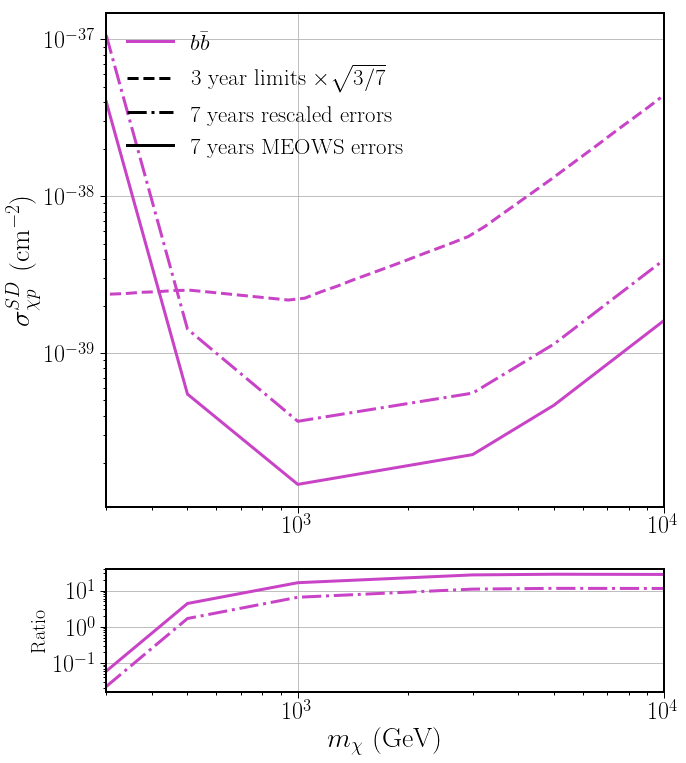

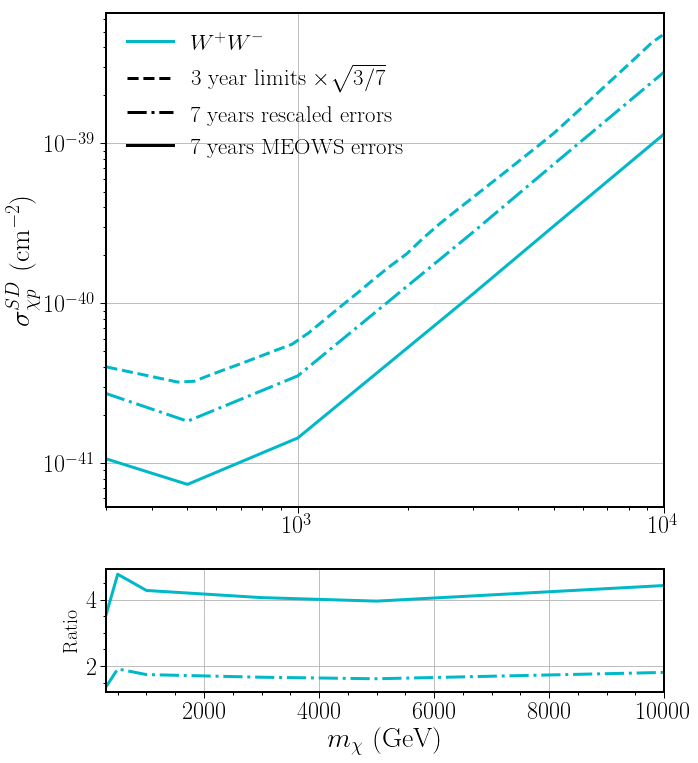

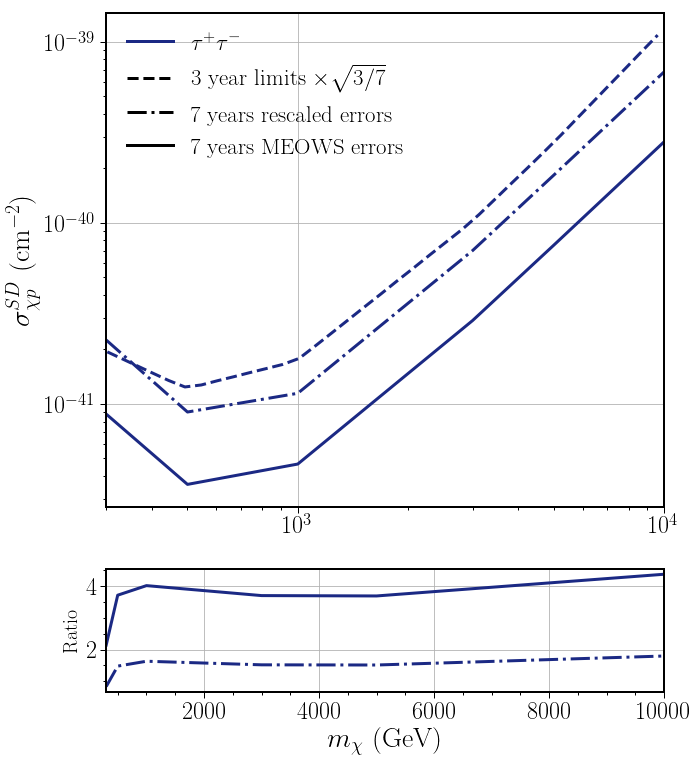

In [155]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1] * scale, "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(get_limit(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"3 year limits $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()

# Use sensitivities instead of limits

((300, 500, 1000, 3000, 5000, 10000), array([ 0.0223619 ,  1.68967089,  6.51597538, 10.94223994, 11.47673641,
       11.39687791]))


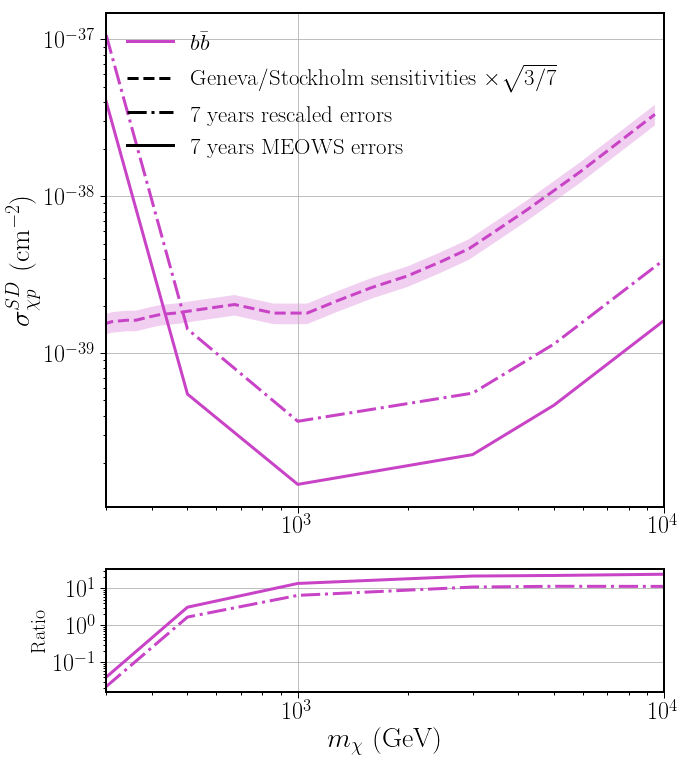

((300, 500, 1000, 3000, 5000, 10000), array([1.38666065, 1.91460505, 1.74574092, 1.66656884, 1.62040745,
       1.81110681]))


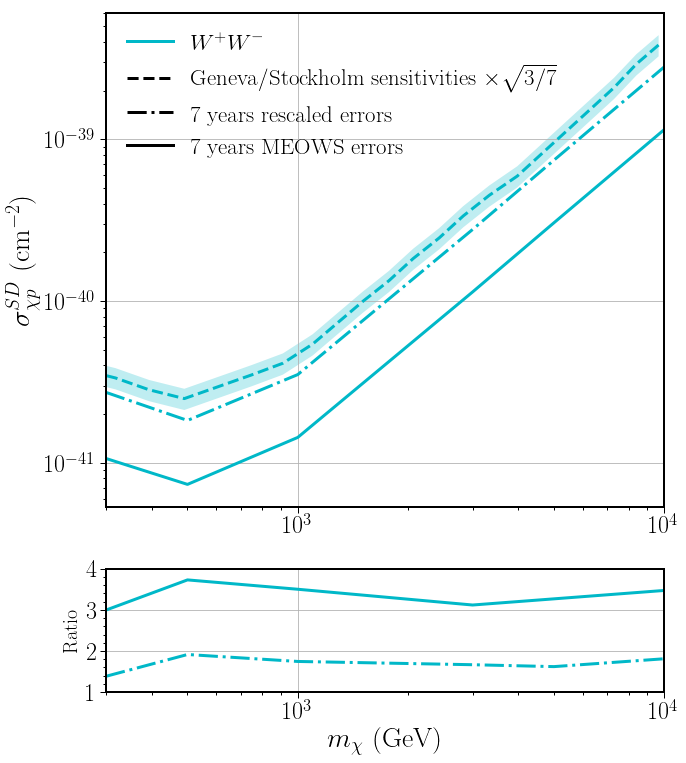

((300, 500, 1000, 3000, 5000, 10000), array([0.8345124 , 1.47763617, 1.63084799, 1.51804079, 1.51238287,
       1.79556907]))


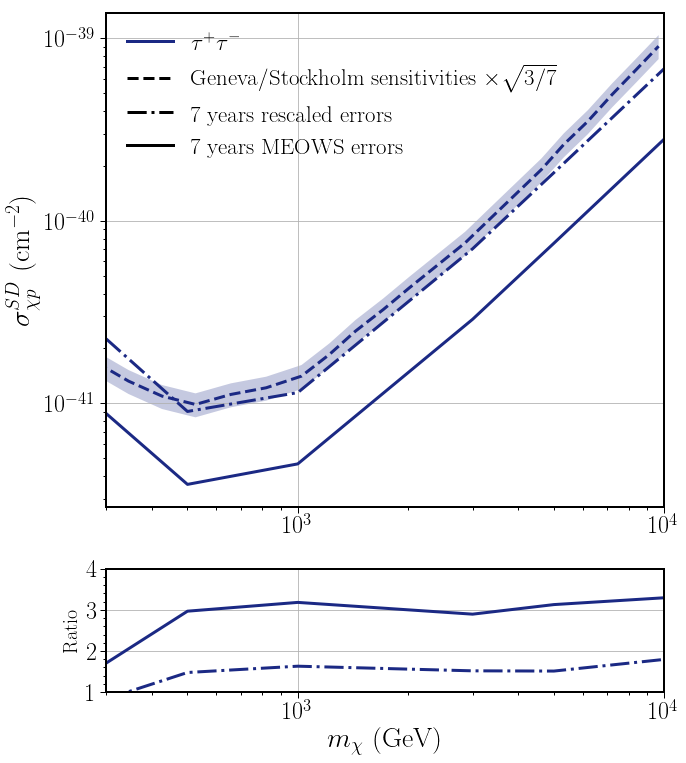

In [156]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1] * scale, "--", color=cs[i], lw=lw)

    
    
    ax2.plot(ms, np.divide(get_sens(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    print(ms, np.divide(old_sens[i] * scale, sens))
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    else:
        ax2.semilogx()
        ax2.set_ylim(1, 4)
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"Geneva/Stockholm sensitivities $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()

In [ ]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))


for i, ch in enumerate(chs):
    
   
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.", lw=lw)
    

ax1.set_xlim(300, 10000)
ax2.set_xlim(300, 10000)
ax1.loglog()
ax2.loglog()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("plots/stat_only_sensitivity_combined_w_ratio.png")

plt.show()

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.")
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_combined_w_ratio.png" % ch)
    
    plt.show()

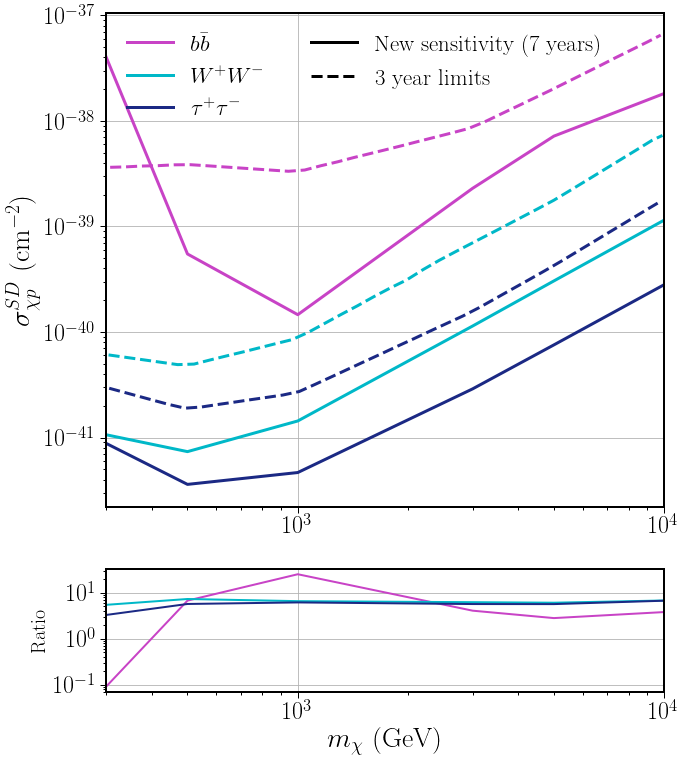

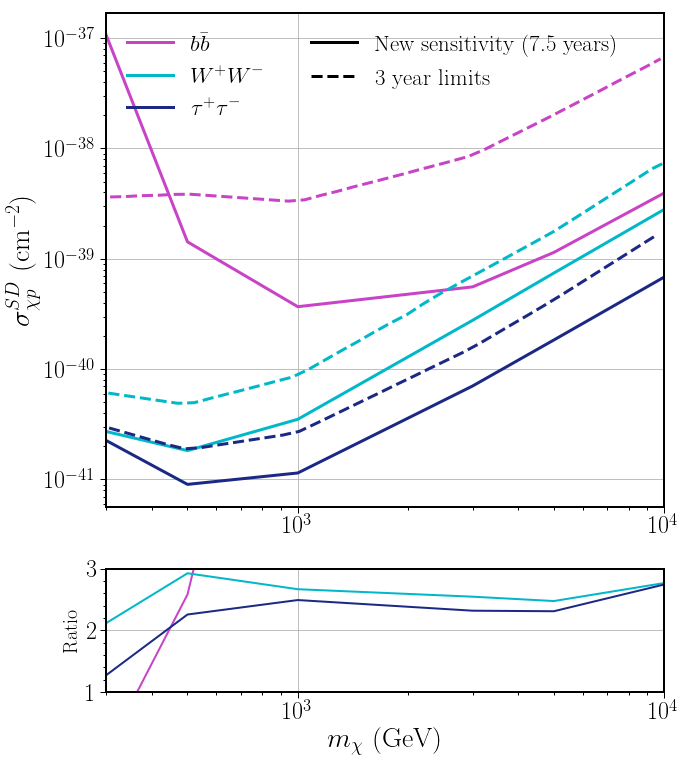

In [28]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
   
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.loglog()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


legend_elements = []

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax2.set_ylim(1,3)
ax1.loglog()
# ax2.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7.5 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_3y_error_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()

((300, 500, 1000, 3000, 5000, 10000), array([0.01407741, 4.7381056 , 2.91184702, 3.26132076, 2.23256826,
       3.30339795]))
((300, 500, 1000, 3000, 5000, 10000), array([4.57535801, 5.691683  , 5.34483569, 4.76024215, 4.98900014,
       5.30033136]))
((300, 500, 1000, 3000, 5000, 10000), array([2.6066389 , 4.5315004 , 4.85708685, 4.42087112, 4.77601105,
       5.02879045]))


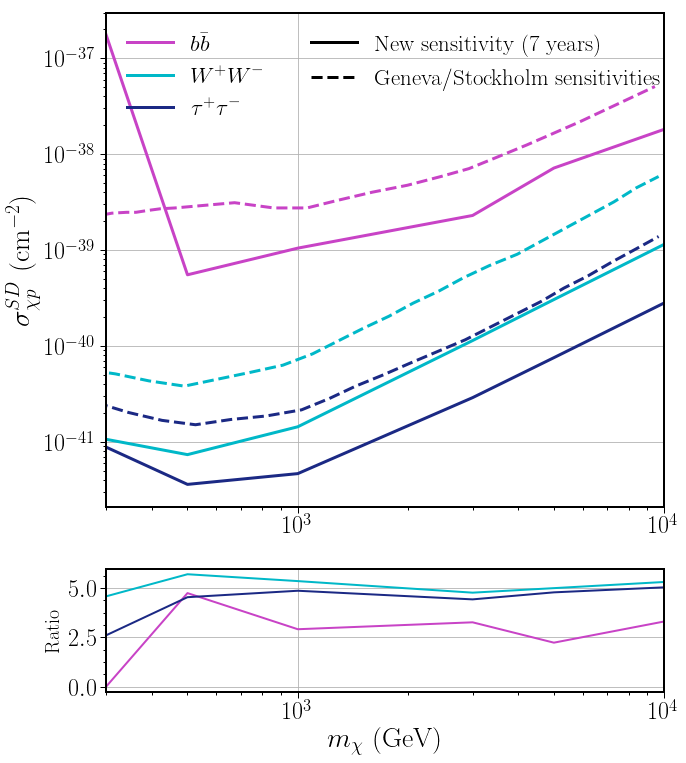

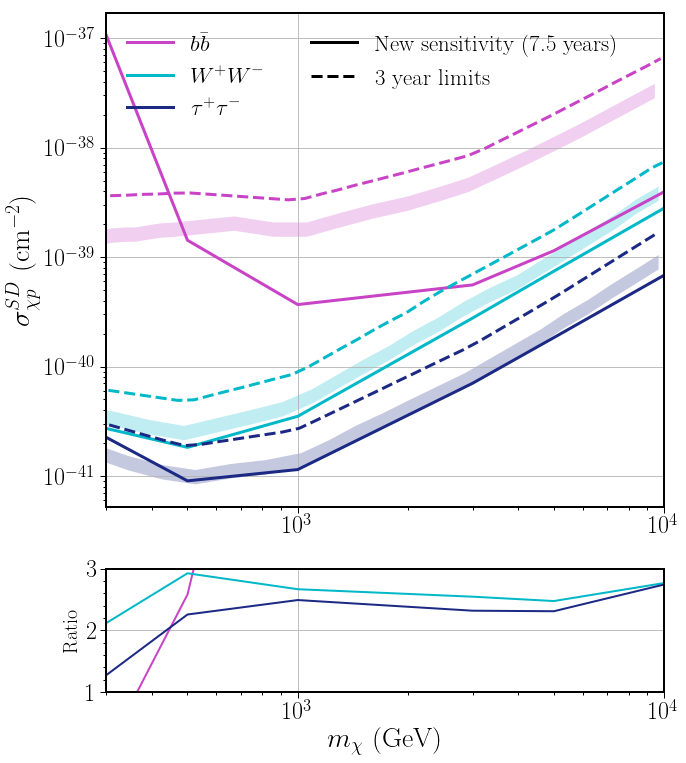

In [37]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]



lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_sens(ms, ch), sens), color=cs[i])
    print(ms, np.divide(get_sens(ms, ch),sens))
   
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="Geneva/Stockholm sensitivities", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


legend_elements = []

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax2.set_ylim(1,3)
ax1.loglog()
# ax2.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Ratio", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7.5 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_3y_error_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


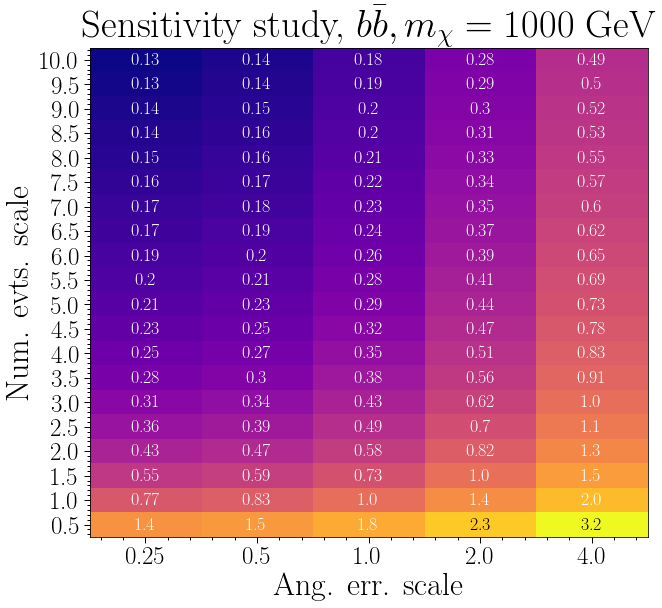

In [71]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 5

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/sens_dict[ch][m])[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        if i==19 and j in [3,4]:
            text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j])),
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j])),
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


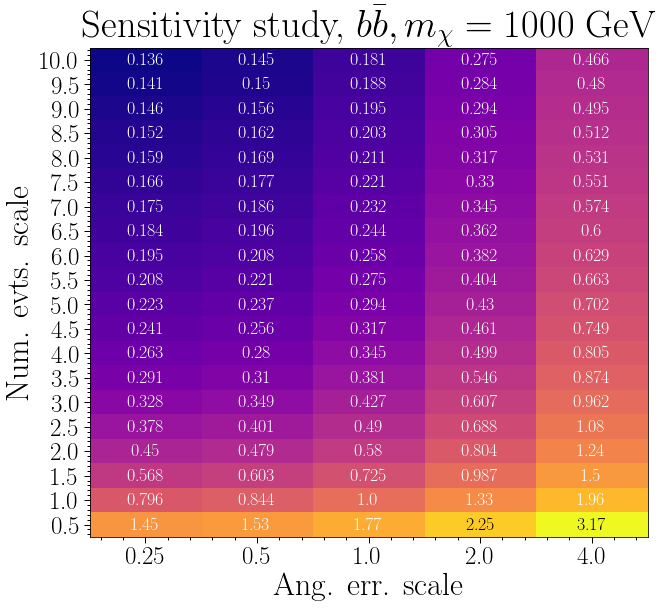

In [75]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 8

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/sens_dict[ch][m])[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        t = round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3)
        if i==19 and j in [3,4]:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

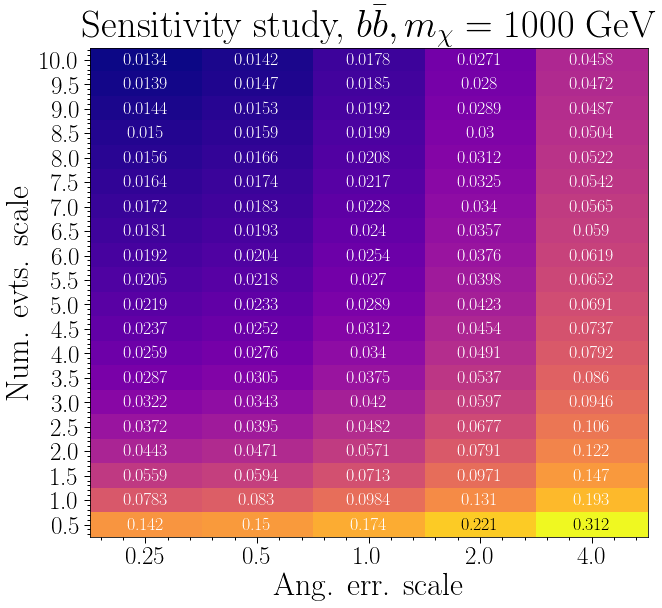

In [76]:
# X,Y=np.meshgrid(ang_err_scals, num_evt_scals)

l_rat = np.log10(sens_arr/1.4585694051687332e-40)[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        t = round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3)
        if i==19 and j in [3,4]:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="black", fontsize=18)
        else:
            text = ax.text(j, i, t,
                       ha="center", va="center", color="w", fontsize=18)
        

plt.show()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


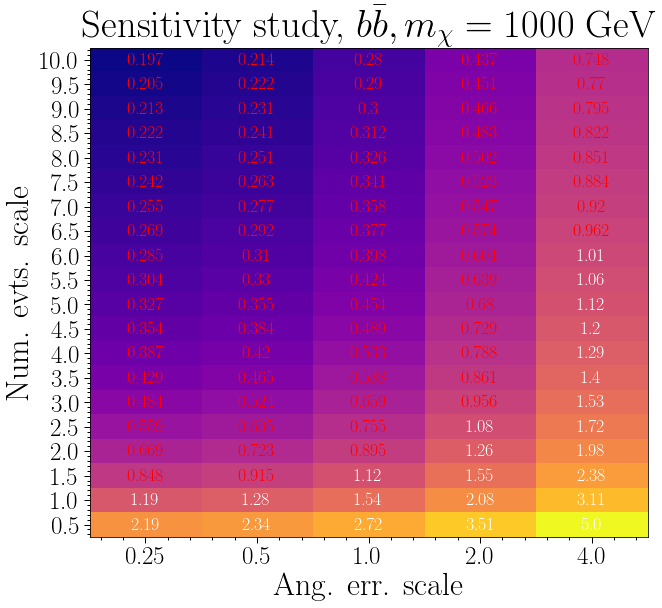

In [73]:
ang_err_scals = np.asarray([4., 2., 1., 0.5, 0.25])
num_evt_scals = np.linspace(0.5, 10, 20)
# arr = np.asarray([1.])
m  = 1000
ch = 5

rb = get_bound(m, "red")
bb = get_bound(m, "blue")


text_cs = np.full(((len(num_evt_scals), len(ang_err_scals))), "white")

delta_t = 30 * 60
factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t

sens_arr = np.full((len(num_evt_scals), len(ang_err_scals)), np.nan)

for k,f in enumerate(ang_err_scals):
    if f!=1:
        h    = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_0_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f)).shape)
        for i in range(100):
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
            h += np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f%f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch, m, f, i))
        mu_s = factor*h.T[::-1].T
    else:
        mu_s = factor*np.load("data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (ch, m)).T
    for j,n in enumerate(num_evt_scals):
        scaled_mu_s = mu_s*n
        sens = calc_sens(n*mu_bg_tot, scaled_mu_s)
        if sens/rb>1:
            text_cs[j,k]="white"
#             print("white", sens, rb)
        elif sens/bb<1:
            text_cs[j,k]="blue"
#             print("blue", sens, bb)
        else:
            text_cs[j,k]="red"
#             print("red", sens, rb)
            
        sens_arr[j,k] = sens
    
l_rat = np.log10(sens_arr/rb)[::-1,::-1]

fig, ax = plt.subplots(figsize=(10,9))
im  = ax.imshow(l_rat, aspect='auto')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r"Ang. err. scale")
plt.ylabel(r"Num. evts. scale")
plt.title(r"Sensitivity study, $b\bar{b}, m_{\chi}=1000$ GeV")

### Get the ticks all did up ###
ax.set_xticks(np.arange(len(ang_err_scals)))
ax.set_yticks(np.arange(len(num_evt_scals)))

ax.set_xticklabels(ang_err_scals[::-1])
ax.set_yticklabels(num_evt_scals[::-1])

plt.tick_params(labelsize=25)

for i in range(len(num_evt_scals)):
    for j in range(len(ang_err_scals)):
        text = ax.text(j, i, round_sig_figs(np.power(10, l_rat[i, j]), sig_figs=3),
                       ha="center", va="center", color=text_cs[::-1,::-1][i,j], fontsize=18)
        

plt.show()

In [12]:
# def x_intersection(x_arr, y_arr, y_int=0):
#     idx = np.argwhere(np.diff(np.sign(y_arr - np.full(len(y_arr), y_int)))).flatten()
#     return x_arr[idx]

In [13]:
# def calc_scale(ch, m, min_ns=0, max_ns=1, num_ns=10000, add=False):
    
#     ns = np.linspace(min_ns, max_ns, num_ns)
# #     yint = 2.71
#     yint = 4.61
#     l    = num_ns
#     ns   = np.linspace(min_ns, max_ns, l)
#     nb   = 1
#     mu_s = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch, m)).T

#     neg_log_likelihood_0 = neg_log_likelihood(0, mu_s, nb, mu_bg_tot)

#     y = np.array([2*(neg_log_likelihood(ns[i], mu_s, nb, mu_bg_tot) - neg_log_likelihood_0) for i in range(l)])
    
#     scale = x_intersection(ns, y, y_int=yint)[0]
    
#     print(scale)
#     return scale

In [14]:
# def converge_ns(ch, m, thresh=0.0001):
#     num_ns = 10000
#     max_ns = 1
#     min_ns = 0
#     oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#     while oldns==0:
#         oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns * 0.1, num_ns=num_ns)
#         max_ns = max_ns * 0.1
#     while oldns==max_ns:
#         oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns * 10, num_ns=num_ns)
#         max_ns = max_ns * 10
#     min_ns = oldns - 0.1
#     max_ns = oldns + 0.1    
#     num_ns = int(1.5 * num_ns)
#     newns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#     err    = np.abs(newns-oldns)/oldns
#     while err > thresh:
#         num_ns = int(1.5 * num_ns)
#         oldns  = newns
#         newns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#         err    = np.abs(newns-oldns)/oldns
#     print(oldns, newns)
#     if ch==5:
#         scale_dict = bb_scale_dict
#     elif ch==8:
#         scale_dict = ww_scale_dict
#     elif ch==11:
#         scale_dict = tt_scale_dict
#     else:
#         print("Channel must be in [5,8,11]")
#     scales_dict[m] = newns

In [15]:
# def clip_2d_array(arr, clip_i=20):
# #     arr = arr.T
# #     arr = arr[:20]
# #     arr = arr.T
#     return arr[:clip_i]

In [12]:
# def rand_poisson(mu, seed=31093):
#     """
#     return random element drawn from poisson distribution with mean of mu
    
#     mu   float: mean of poisson distributuion to draw from
#     seed int  : seed for random number generator
#     """
#     np.random.seed(seed)
#     dist    = poisson(mu)
#     std_dev = dist.std
#     x       = np.linspace(0, mu + 10*std_dev, 10000000)
#     p       = dist.pdf(x) / np.sum(dist.pdf(x))
#     print(np.sum(p))
#     return np.random.choice(x, p=p)

## Load in signal and background

In [13]:
# def ll_plot(ch, m, min_ns=0, max_ns=1, save=False, show=True, num_ns=10000):
    
#     if ch==5:
#         desc_str = r"$b\bar{b}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==8:
#         desc_str = r"$W^{+}W^{-}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==11:
#         desc_str = r"$\tau^{+}\tau^{-}$, $m_{\chi}=%d$ GeV" % m
#     else:
#         print("Channel must be in [5,8,11]")
    
#     yint = 2.71
#     l    = num_ns
#     ns   = np.linspace(min_ns, max_ns, l)
#     nb   = 1
#     mu_s = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch, m)).T

#     neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_bg_tot, nb)

#     y = np.array([2*(neg_log_likelihood(mu_s, ns[i], mu_bg_tot, nb) - neg_log_likelihood_0) for i in range(l)])
#     ymax = max(y)
    
#     xint = x_intersection(ns, y, y_int=yint)[0]

#     plt.plot(ns, y)
#     print(min_ns)
#     print(xint / (max_ns+min_ns))
#     plt.axhline(y=yint, xmin=0, xmax=(xint-min_ns) / (max_ns-min_ns))
#     plt.axvline(x=xint, ymin=0, ymax=yint / ymax)
#     plt.text(xint, 0, r"$n_{s}=%s$" % str(round_sig_figs(xint, sig_figs=3)))
#     plt.plot(xint, yint, 'ro')

#     plt.ylabel(r"$-2\Delta LLH$")
#     plt.xlabel(r"$n_{s}$")
#     plt.title(desc_str)
    
#     plt.ylim(0, ymax)
#     plt.xlim(min_ns, max_ns)

#     plt.grid()

# #     ticks, labels = plt.xticks()
# #     ticks = np.append(ticks, [xint])
# #     plt.xticks(ticks)

#     if save:
#         plt.savefig("/Users/jlazar/Documents/IceCube/ch%d_m%d_lh.png" % (ch, m))
    
#     if show:
#         plt.show()
#     print(xint)

In [8]:


# cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', "gnuplot2"]

# ms = [400,500,1000,3000,5000,10000]
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)
# for c in cmaps:
    
#     cmap       = plt.get_cmap(c)
#     c_norm     = colors.Normalize(vmin=0, vmax=n_chans)
#     scalar_map = cm.ScalarMappable(norm=c_norm, cmap=cmap)
#     cs         = [scalar_map.to_rgba(i) for i in range(n_chans)][::-1]

#     old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#                 np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#                 np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#                ]
    
#     # set up the legend
#     legend_elements = []
    
                  
    
    
#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
        
#         ax.plot(ms, [sd_limits[ch][m]*scales[ch][m]*1.e-36 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(500,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
# #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)
    
#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":24}, frameon=False)
    
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()

In [9]:
# ms = [400,500,800,1000,3000,5000,10000]
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)

# colors   = [["#00B8C8", "#C843C6", "#1B2984"],
#             ["#C843C6", "#00B8C8", "#1B2984"]
#            ]

# old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#            ]
# for cs in colors:
#     # set up the legend
#     legend_elements = []




#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))

#         ax.plot(ms, [sd_limits[ch][m]*scales_dict[ch][m]*1.e-36 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(500,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
#     #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()

In [22]:
# for m in [400, 800,]:
#     for ch in chs:
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m), frown*1e-3)
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m), frown*1e-3)
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_bar_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_bar_e_d_theta_hist_course.npy" %(ch,m), frown*1.e-3)
#         for nt in ["nu","nuBar"]:
#             for i in range(100):
#                 frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/partial_hists/ch%d_m%d_%s_%d_energy_delta_theta_hist_course.npy" %(ch,m,nt,i))
#                 np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/partial_hists/ch%d_m%d_%s_%d_energy_delta_theta_hist_course.npy" %(ch,m,nt,i), frown*1.e-3)    

In [18]:
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)

# colors   = [["#00B8C8", "#C843C6", "#1B2984"],
#             ["#C843C6", "#00B8C8", "#1B2984"]
#            ]

# old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#            ]
# for cs in colors:
#     # set up the legend
#     legend_elements = []




#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))

#         ax.plot(ms, [scale_dict[ch][m]*1.e-39 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(400,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
#     #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()

In [66]:
calc_sens(3000000000,3)

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


2.277783544600302e-43

In [64]:
neg_log_likelihood([3,3], [1,1], [3,3], [1,1])

4.83296212308778

In [65]:
neg_log_likelihood([3,3], [1,1], [4,4], [1,1])

4.788826468253385

In [36]:
for m in [1000, 500,3000,5000,10000,300]:
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch5_m10000_f1.000000_nu_0_energy_delta_theta_hist_im_gonna_scream.npy").shape)
    for i in range(100):
        h+=np.load("data/e_d_theta_hist/partial_hists/ch5_m%d_f1.000000_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (m,i))
        h+=np.load("data/e_d_theta_hist/partial_hists/ch5_m%d_f1.000000_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (m,i))
    mu_s = factor*h.T[::-1].T
    sens = calc_sens(mu_bg_tot, mu_s)
    sens_dict[5][m] = sens
    print(sens)


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


1.0478827134438623e-39
5.522938986643158e-40
2.2968262896621926e-39
7.172981334981606e-39
1.8182845771194386e-38
1.7466708589850702e-37


In [146]:
h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/kaon_bar_f_0_energy_delta_theta_hist_bg.npy").shape)
for j in range(10):
    h+=np.load("data/e_d_theta_hist/partial_hists/kaon_f_%d_energy_delta_theta_hist_bg.npy" % j)
    h+=np.load("data/e_d_theta_hist/partial_hists/kaon_bar_f_%d_energy_delta_theta_hist_bg.npy" % j)
    h+=np.load("data/e_d_theta_hist/partial_hists/pion_f_%d_energy_delta_theta_hist_bg.npy" % j)
    h+=np.load("data/e_d_theta_hist/partial_hists/pion_bar_f_%d_energy_delta_theta_hist_bg.npy" % j)
mu_bg_tot_new = h    

chs = [5,8,11][::-1]
ms  = [1000, 500,3000,5000,300,10000,]
new_sens_dict = {ch:{} for ch in chs}
for ch in chs:
    for m in ms:
        factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
        h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch5_m1000_f1.000000_f_nu_0_energy_delta_theta_hist_im_gonna_scream.npy").shape)
        for i in range(25):
            h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
            h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
        mu_s = factor*h.T[::-1].T
        sens = calc_sens(mu_bg_tot_new, mu_s)
        new_sens_dict[ch][m] = sens
        print(sens)


4.5831632510110443e-42
3.5512743822043666e-42
2.82961157517046e-41
7.390629954533482e-41
8.703552490132614e-42
2.750747337577139e-40
1.410837197135213e-41
7.241391060430524e-42
1.114754184967755e-40
2.9854241113052596e-40
1.051194723626387e-41
1.1251802475701255e-39
1.0349874130882863e-39
5.484781255004628e-40
2.2610844917412247e-39
7.058068342987877e-39
1.7282365240738266e-37


IOError: [Errno 2] No such file or directory: 'data/e_d_theta_hist/partial_hists/ch5_m10000_f1.000000_f_nu_0_energy_delta_theta_hist_im_gonna_scream.npy'

((300, 500, 1000, 3000, 5000, 10000), array([ 0.0223619 ,  1.68967089,  6.51597538, 10.94223994, 11.47673641,
       11.39687791]))


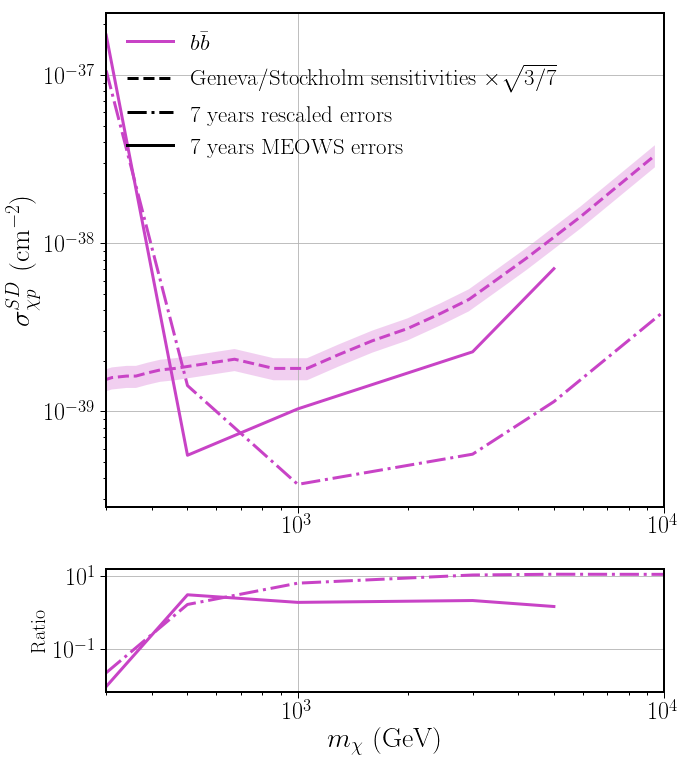

((300, 500, 1000, 3000, 5000, 10000), array([1.38666065, 1.91460505, 1.74574092, 1.66656884, 1.62040745,
       1.81110681]))


In [ ]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]
old_sens = [get_limit([300, 500, 1000, 3000, 5000, 10000], ch) for ch in chs]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]


scale = np.sqrt(3./7)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(new_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.fill_between(senss[i][0], senss[i][1] * scale*0.85, senss[i][1] * scale*1.15, facecolor=cs[i], alpha=0.25)
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(senss[i][0], senss[i][1] * scale, "--", color=cs[i], lw=lw)

    
    
    ax2.plot(ms, np.divide(get_sens(ms, ch) * scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    
    ax2.plot(ms, np.divide(old_sens[i] * scale, sens), color=cs[i], linestyle="-.", lw=lw)
    print(ms, np.divide(old_sens[i] * scale, sens))
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    if ch==5:
        ax2.loglog()
    else:
        ax2.semilogx()
        ax2.set_ylim(1, 4)
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Ratio", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"Geneva/Stockholm sensitivities $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch, dpi=400, bbox_inches="tight")
    
    plt.show()